In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#create dataframe to read dataset
df1=pd.read_csv(r'C:\Users\DELL\OneDrive\Desktop\shortlisted resumes\best ones\endtoend-ml-projects-master\hr_employee_churn_data.csv')

In [ ]:
#check the dataframe and its data
df1.head()

In [ ]:
# check the num of rows and columns in dataframe
df1.shape

In [ ]:
df1.info()

# Feature Engineering

In [ ]:
df2=df1.copy()

In [ ]:
df2.drop(['empid'],axis=1,inplace=True)

In [ ]:
df2.head()

In [ ]:
#handle missing values
df2.isnull().sum()

In [ ]:
df2['satisfaction_level'].describe()

In [ ]:
df2['satisfaction_level'].fillna(df2['satisfaction_level'].mean(), inplace=True)

In [ ]:
df2.isnull().sum()

In [ ]:
#handle categorical features..salary using get dummies
df2['salary'].unique()

In [ ]:
salary_dummies = pd.get_dummies(df2['salary'],drop_first=True)

In [ ]:
salary_dummies

In [ ]:
df2=pd.concat([df2,salary_dummies],axis=1)

In [ ]:
df2.head()

In [ ]:
#drop salary feature as we already applied lable endcoding tech
df2.drop(['salary'],axis=1,inplace=True)

In [ ]:
df2.head()

# Split Dataset into Training set and Test set

In [ ]:
#split dataset into features and label
X= df2.drop(labels='left',axis=1)
y= df2['left']

In [ ]:
#split dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

# Model Selection

In [ ]:
# will try to use below two models that are RandomForestClassifier and XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#create param
model_param = {
    'RandomForestClassifier':{
        'model':RandomForestClassifier(),
        'param':{
            'n_estimators': [10, 50, 100, 130], 
            'criterion': ['gini', 'entropy'],
            'max_depth': range(2, 4, 1), 
            'max_features': ['auto', 'log2']
        }
    },
    'XGBClassifier':{
        'model':XGBClassifier(objective='binary:logistic'),
        'param':{
           'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3, 5, 10, 20],
            'n_estimators': [10, 50, 100, 200]
        }
    }
}

In [26]:
scores =[]
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'],cv=5,return_train_score=False)
    model_selection.fit(X,y)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })
    

In [27]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.9213963098810714,
  'best_params': {'criterion': 'entropy',
   'max_depth': 3,
   'max_features': 'auto',
   'n_estimators': 10}},
 {'model': 'XGBClassifier',
  'best_score': 0.9902661776147605,
  'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}}]

# Model Building

In [28]:
#as per above results, xgboost gives best result and hence selecting same to model building...
model_xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.1,max_depth=20,n_estimators=200)

In [29]:
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [30]:
model_xgb.score(X_test,y_test)

0.9923333333333333

In [31]:
X_test.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,low,medium
1670,0.44,0.57,2,141,3,0,0,0,1
13378,0.55,0.96,3,194,3,0,0,0,1
10233,0.72,0.67,5,210,2,0,0,0,1
4719,0.96,0.75,4,177,2,0,0,1,0
7003,0.96,0.54,3,198,3,0,0,1,0


In [32]:
X_test[:1]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,low,medium
1670,0.44,0.57,2,141,3,0,0,0,1


In [33]:
model_xgb.predict(X_test[:1])

array([1])

In [34]:
df1.loc[1670]

empid                      1671
satisfaction_level         0.44
last_evaluation            0.57
number_project                2
average_montly_hours        141
time_spend_company            3
Work_accident                 0
promotion_last_5years         0
salary                   medium
left                          1
Name: 1670, dtype: object

In [35]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,model_xgb.predict(X_test))
cm

array([[2292,    7],
       [  16,  685]], dtype=int64)

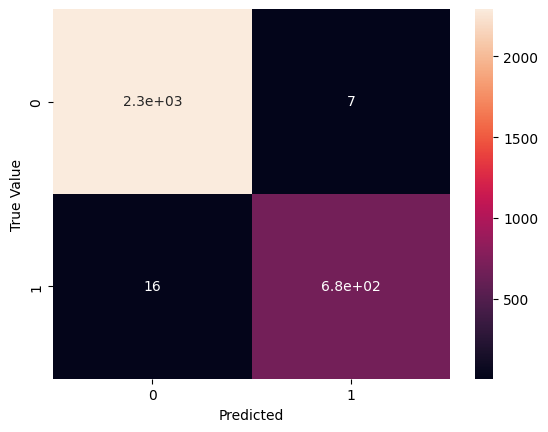

In [36]:
#plot the graph
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()

In [37]:
import pickle
filepath=r"C:\Users\DELL\OneDrive\Desktop\shortlisted resumes\best ones\endtoend-ml-projects-master\jupyter code\model_xgb.pickle"
pickle.dump(model_xgb,open(filepath,"wb"))


In [38]:
pickled_model=pickle.load(open(filepath,"rb"))